# Analysis Trump/Clinton Tweets - 2016

### Objective: Use statistics, some time series and machine learning to characterize 'tweeter speech' from Donald Trump/Hillary Clinton 

Analysis keypoints:
 1. Use tweepy to download the tweets authored by Donald Trump.
 2. Analysis of Hashtag frequency - What can we learn?
 3. Time series analysis - Number of tweets/correlation - Locate peaks
 4. Word histogram - What are the words more frequently used by either candidate? What can we learn?
 5. But... humans are biased, are they not? Can we do better? Use machine learning!
 6. What about unsupervised learning? Does a predictive model make sense?

In [1]:
#Import the data. The tweets were downloaded using Tweepy.
import json, glob
import datetime
import pandas as pd
from __future__ import division

In [2]:
dt_tweets_json = []
hc_tweets_json = []
for fn in glob.glob('data/*'):
    with open(fn, 'r') as f:
        if 'Clinton' in fn:
            for line in f:
                hc_tweets_json.append(json.loads(line))
        else:
            for line in f:
                dt_tweets_json.append(json.loads(line))

df_dt = pd.DataFrame(dt_tweets_json).drop_duplicates(subset='id_str', keep='last')
df_dt = df_dt.set_index('id_str', inplace=False)
df_hc = pd.DataFrame(hc_tweets_json).drop_duplicates(subset='id_str', keep='last')
df_hc = df_hc.set_index('id_str', inplace=False)

In [3]:
to_datetime = lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")
df_dt['created_at'] = df_dt['created_at'].apply(to_datetime)
df_hc['created_at'] = df_hc['created_at'].apply(to_datetime)

In [4]:
df_hc.head(3)

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,in_reply_to_screen_name,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
id_str,,,,,,,,,,,,,,,,,,,,,
751245220222689280,None,None,2016-07-08 02:43:12,"{u'symbols': [], u'user_mentions': [], u'hasht...",NaN,2582,False,None,751245220222689280,None,...,NaN,NaN,NaN,763,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",We have a responsibility to fight for the next...,False,"{u'follow_request_sent': False, u'has_extended..."
751237421040275456,None,None,2016-07-08 02:12:13,"{u'symbols': [], u'user_mentions': [{u'indices...",NaN,0,False,None,751237421040275456,None,...,NaN,NaN,NaN,253,False,"{u'contributors': None, u'truncated': False, u...","<a href=""http://twitter.com/download/iphone"" r...",RT @mpshapiro: See new @Hillaryclinton plan to...,False,"{u'follow_request_sent': False, u'has_extended..."
751199631728607232,None,None,2016-07-07 23:42:03,"{u'symbols': [], u'user_mentions': [], u'hasht...",{u'media': [{u'expanded_url': u'http://twitter...,9107,False,None,751199631728607232,None,...,NaN,NaN,NaN,4361,False,NaN,"<a href=""https://about.twitter.com/products/tw...",Too many African American families are mournin...,False,"{u'follow_request_sent': False, u'has_extended..."


## 2. Temporal analysis - Who tweets the most?

In [5]:
#Extract number of tweets per date, create dictionaries with information.
from collections import Counter

hc_tweets_per_day = Counter([x.date() for x in df_hc.created_at if x.year > 2015])
dt_tweets_per_day = Counter([x.date() for x in df_dt.created_at if x.year > 2015])
hc_tweets_per_day_noRT = Counter([x.date() for x in df_hc[['RT ' not in x for x in df_hc.text.values]].created_at if x.year > 2015])
dt_tweets_per_day_noRT = Counter([x.date() for x in df_dt[['RT ' not in x for x in df_dt.text.values]].created_at if x.year > 2015])
hc_tweets_per_day_only_RT = Counter([x.date() for x in df_hc[['RT ' in x for x in df_hc.text.values]].created_at if x.year > 2015])
dt_tweets_per_day_only_RT = Counter([x.date() for x in df_dt[['RT ' in x for x in df_dt.text.values]].created_at if x.year > 2015])
#dt_tweets_per_day = Counter([x.date() for x in dt_tweets_json if to_datetime(x).year > 2015])

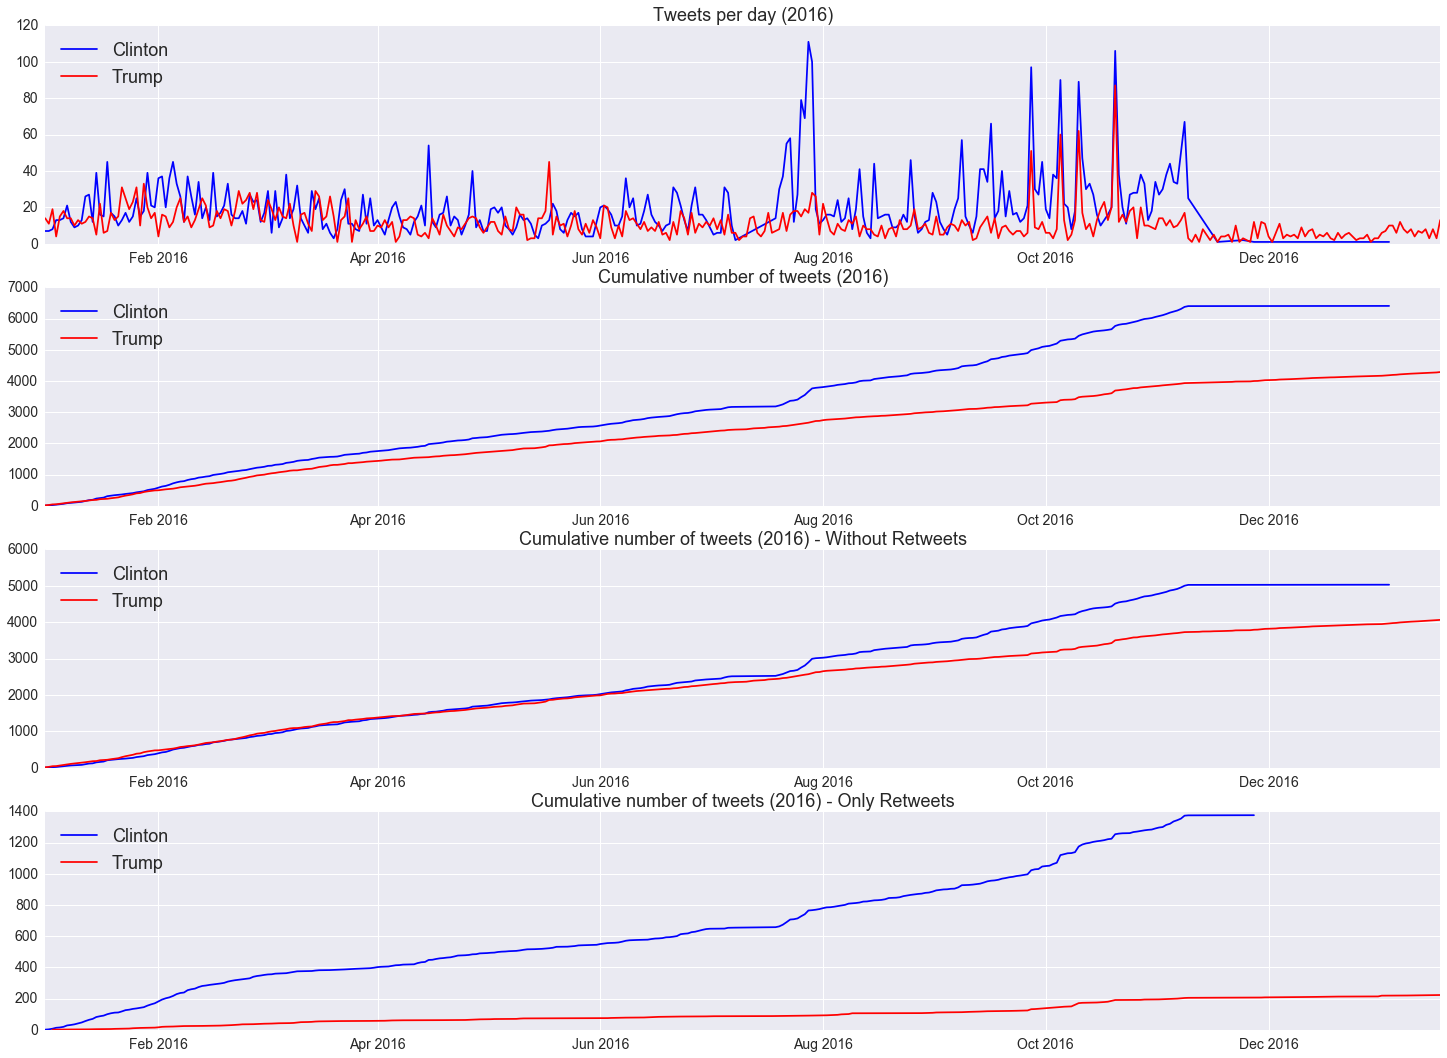

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(25,18))
plt.subplot(4, 1, 1)
pd.Series(hc_tweets_per_day).plot(title = 'Tweets per day (2016)', label = 'Clinton', color = 'b', fontsize = 14)
pd.Series(dt_tweets_per_day).plot(label = 'Trump', color = 'r')
plt.title('Tweets per day (2016)', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)

plt.subplot(4, 1, 2)
pd.Series(hc_tweets_per_day).cumsum().plot(title = 'Cumulative number of tweets (2016)', label = 'Clinton', color = 'b', fontsize = 14)
pd.Series(dt_tweets_per_day).cumsum().plot(label = 'Trump', color = 'r')
plt.title('Cumulative number of tweets (2016)', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)

plt.subplot(4, 1, 3)
pd.Series(hc_tweets_per_day_noRT).cumsum().plot(title = 'Cumulative number of tweets (2016) - Without Retweets', label = 'Clinton', color = 'b',
                                               fontsize = 14)
pd.Series(dt_tweets_per_day_noRT).cumsum().plot(label = 'Trump', color = 'r')
plt.title('Cumulative number of tweets (2016) - Without Retweets', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)

plt.subplot(4, 1, 4)
pd.Series(hc_tweets_per_day_only_RT).cumsum().plot(title = 'Cumulative number of tweets (2016) - Only Retweets', label = 'Clinton', color = 'b', 
                                                  fontsize = 14)
pd.Series(dt_tweets_per_day_only_RT).cumsum().plot(label = 'Trump', color = 'r')
plt.title('Cumulative number of tweets (2016) - Only Retweets', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)
plt.show()

In [7]:
sorted_tweets_hc = [(tweets, date) for date, tweets in hc_tweets_per_day.items()]
sorted_tweets_hc.sort(reverse=True)
sorted_tweets_dt = [(tweets, date) for date, tweets in dt_tweets_per_day.items()]
sorted_tweets_dt.sort(reverse=True)

In [8]:
print 'Date of max tweets (Clinton): ' + str(sorted_tweets_hc[0][1]) + ' -- number of tweets: ' + str(sorted_tweets_hc[0][0])
print 'Date of max tweets (Trump): ' + str(sorted_tweets_dt[0][1]) + ' -- number of tweets: ' + str(sorted_tweets_dt[0][0])

Date of max tweets (Clinton): 2016-07-28 -- number of tweets: 111
Date of max tweets (Trump): 2016-10-20 -- number of tweets: 87


In [9]:
pd.Series(hc_tweets_per_day).cumsum().values[-1]

6407

In [10]:
pd.Series(dt_tweets_per_day).cumsum().values[-1]

4287

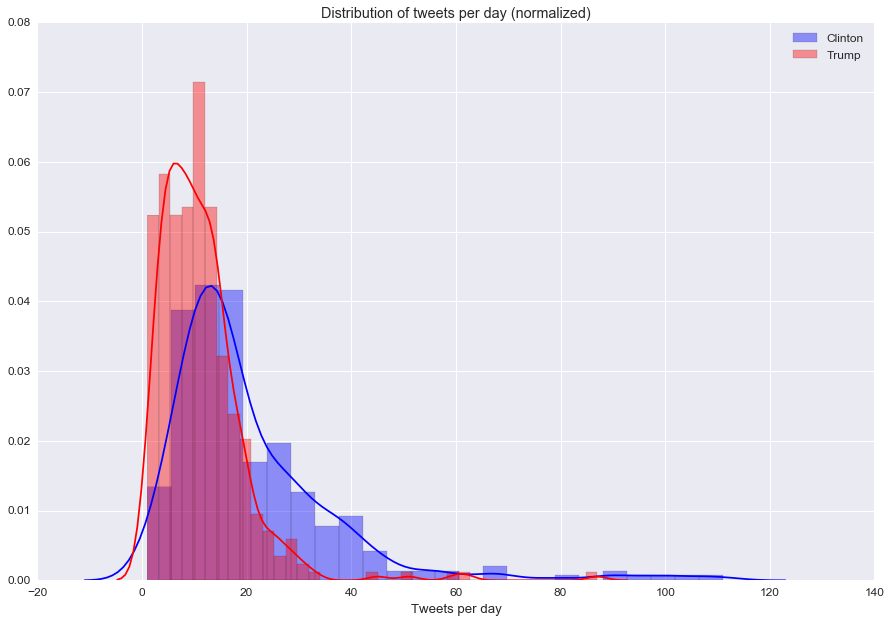

In [11]:
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(1,1, figsize = (15,10))
    sns.distplot(hc_tweets_per_day.values(), color='b', label='Clinton')
    sns.distplot(dt_tweets_per_day.values(), color='r', label='Trump')
    plt.xlabel('Tweets per day')
    plt.title("Distribution of tweets per day (normalized)")
    plt.legend()
plt.show()

Trump's tweets per day are less frequent, with a distribution heavily skewed towards the low end. 

In [12]:
import numpy as np
print np.mean(hc_tweets_per_day.values()), np.mean(dt_tweets_per_day.values())
print np.std(hc_tweets_per_day.values()), np.std(dt_tweets_per_day.values())

20.7346278317 11.2519685039
16.7010880294 8.6724911314


## 3. Hashtag frequency Trump/Clinton  (2016) - (Simple demo of NLTK usage.)

In [13]:
'''
class TOKENIZE():
    def getCLEAN(self, text):
        text = text.replace('\n',' ')
        text = text.replace('...',' TK.PUNCTUAION.ELLIPSES ')
        text = text.replace(u'\ufe0f', 'TK.SPECIALCHAR.UNSPECIFIED')
        text = text.replace(u'\u00a0','') #single quotation mark
        text = text.replace(u'\u2018',' TK.QUOTATION.SINGLE ')
        text = text.replace(u'\u2019',' TK.QUOTATION.SINGLE ')
        text = text.replace(u'\u201c',' TK.QUOTATION.DOUBLE ')
        text = text.replace(u'\u201d',' TK.QUOTATION.DOUBLE ')
        text = text.replace(u'\u2605',' TK.SPECIALCHAR.STAR ')
        text = text.replace(u'\u266a',' TK.SPECIALCHAR.NOTE ')
        return text

    def getLINK(self, text):
        return re.sub('(htt|www).?[^\s]+', ' TK.LINK ', text)

    def getMENTION(self, text):
        return re.sub('@.?[^\s]+', ' TK.MENTION ', text)
    
    Etc, etc...

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-13-e104f71c6d87>, line 22)

In [14]:
#Import modules. We'll use the tweeter tokenizer

import nltk
from nltk.tokenize import TweetTokenizer

In [15]:
#Extract tweets from 2016 - Create mask for dataframe

dt_mask_2016 = ((df_dt.created_at >= datetime.datetime.strptime('2016-01-01',"%Y-%m-%d")) & (df_dt.created_at < datetime.datetime.strptime('2017-01-01',"%Y-%m-%d")))
hc_mask_2016 = ((df_hc.created_at >= datetime.datetime.strptime('2016-01-01',"%Y-%m-%d")) & (df_hc.created_at < datetime.datetime.strptime('2017-01-01',"%Y-%m-%d")))

In [16]:
#Use tokenizer to extract hashtags:

tknzr = TweetTokenizer()
dt_hastags = Counter([y.lower() for x in df_dt[dt_mask_2016].text for y in tknzr.tokenize(x) if (y[0] =='#' and len(y)>1)]) 
hc_hastags = Counter([y.lower() for x in df_hc[hc_mask_2016].text for y in tknzr.tokenize(x) if (y[0] =='#' and len(y)>1)]) 

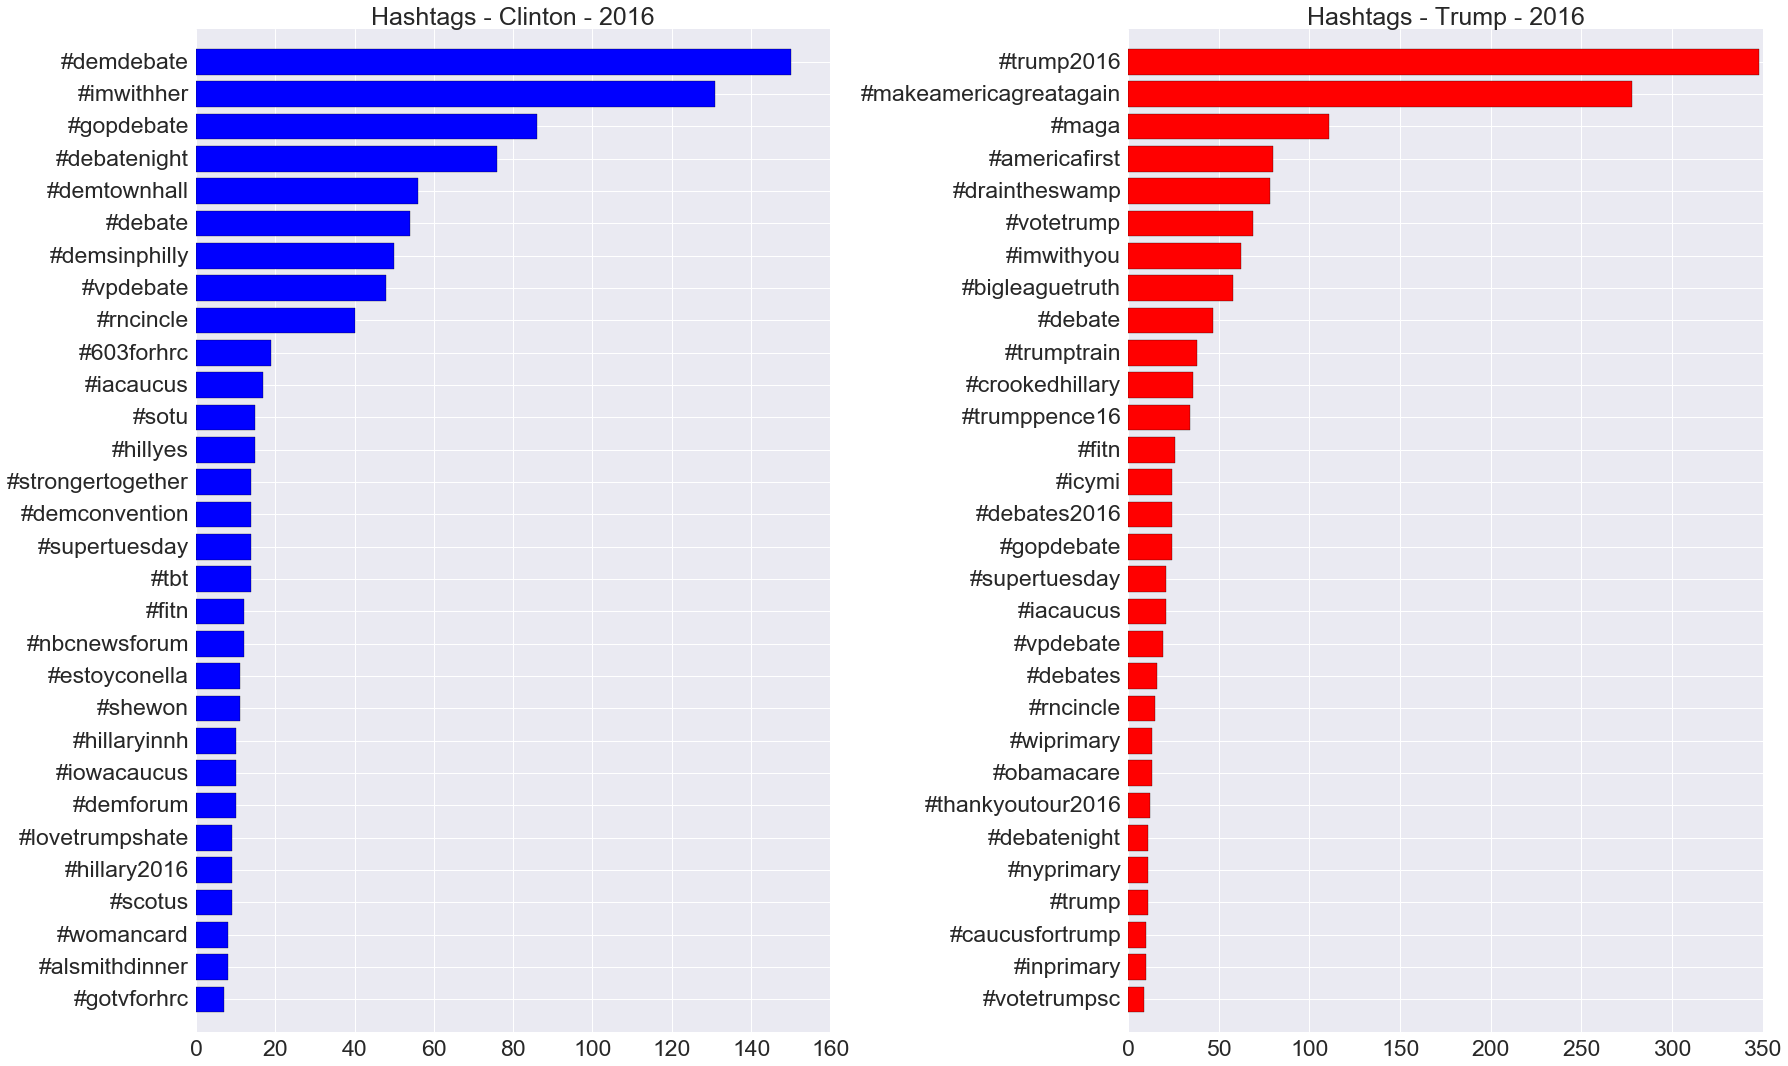

In [17]:
#Barplot of hashtags.

#plt.style.use('ggplot')
n_hast = 30
fig, axes = plt.subplots(1,2, figsize=(25,15))

axes[0].barh(range(n_hast), [x[1] for x in hc_hastags.most_common(n_hast)], align = 'center', color = 'b')
axes[0].set_yticks(range(n_hast))
axes[0].set_yticklabels([x[0] for x in hc_hastags.most_common(n_hast)], fontsize=20)
axes[0].set_title(r'Hashtags - Clinton - 2016', fontsize = 25)
axes[0].set_ylim(bottom=-1)
plt.tight_layout()
axes[0].grid(True)
axes[0].invert_yaxis()
axes[0].tick_params(labelsize=23)

axes[1].barh(range(n_hast), [x[1] for x in dt_hastags.most_common(n_hast)], align = 'center', color = 'r')
axes[1].set_yticks(range(n_hast))
axes[1].set_yticklabels([x[0] for x in dt_hastags.most_common(n_hast)], fontsize=20)
axes[1].set_title(r'Hashtags - Trump - 2016', fontsize = 25)
axes[1].set_ylim(bottom=-1)
axes[1].invert_yaxis()
axes[1].tick_params(labelsize=23)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 4. Words used in tweets for either candidate - histogram

Again, use the tokenizer of the very good NLTK module:

In [18]:
#Use tokenizer to extract hashtags:

tknzr = TweetTokenizer()
dt_words = Counter([y.lower() for x in df_dt[dt_mask_2016].text for y in tknzr.tokenize(x) if (len(y)>1)]) 
hc_words = Counter([y.lower() for x in df_hc[hc_mask_2016].text for y in tknzr.tokenize(x) if (len(y)>1)]) 

In [19]:
dt_words.most_common(10) #Sample before filtering:

[(u'the', 2338),
 (u'to', 1505),
 (u'in', 1202),
 (u'and', 1200),
 (u'is', 1000),
 (u'you', 996),
 (u'of', 985),
 (u'will', 807),
 (u'for', 764),
 (u'on', 748)]

Not very good, lots of stop words and links, retweets, etc. This needs cleaning

In [20]:
#Import module for stopwords
from nltk.corpus import stopwords

In [21]:
def cleanupDoc(tweet, onlytext = True):
    stopset = set(stopwords.words('english'))
    tokens = tknzr.tokenize(tweet) #use the twitter tokenizer
    cleanup = [token.lower() for token in tokens if token.lower() not in stopset and token.lower() != '...' and len(token)>2]
    cleanup2 = []
    for x in cleanup:
        if 'http' in x:
            x = 'LINK'
        elif '@' in x:
            x = 'MENTION'
        elif '#' in x:
            x = 'HASHTAG'
        else:
            pass
        if onlytext:
            if x not in ['LINK', 'MENTION', 'HASHTAG']:
                cleanup2.append(x)
        else:
            cleanup2.append(x)
    return cleanup2

In [22]:
dt_tweets_2016 = [x for x in df_dt[dt_mask_2016].text]
temp = []
for tweet in dt_tweets_2016:
    temp.extend(cleanupDoc(tweet, onlytext=True))
dt_tweets_count_2016 = Counter(temp)

In [23]:
hc_tweets_2016 = [x for x in df_hc[hc_mask_2016].text]
temp = []
for tweet in hc_tweets_2016:
    temp.extend(cleanupDoc(tweet, onlytext=True))
hc_tweets_count_2016 = Counter(temp)

In [24]:
dt_tweets_count_2016.most_common(10)

[(u'thank', 641),
 (u'great', 578),
 (u'hillary', 460),
 (u'trump', 423),
 (u'clinton', 281),
 (u'people', 278),
 (u'america', 265),
 (u'new', 238),
 (u'crooked', 231),
 (u'make', 220)]

With this clean, tokenized version of the tweets, we get bar diagrams to check the most commonly used words by each:

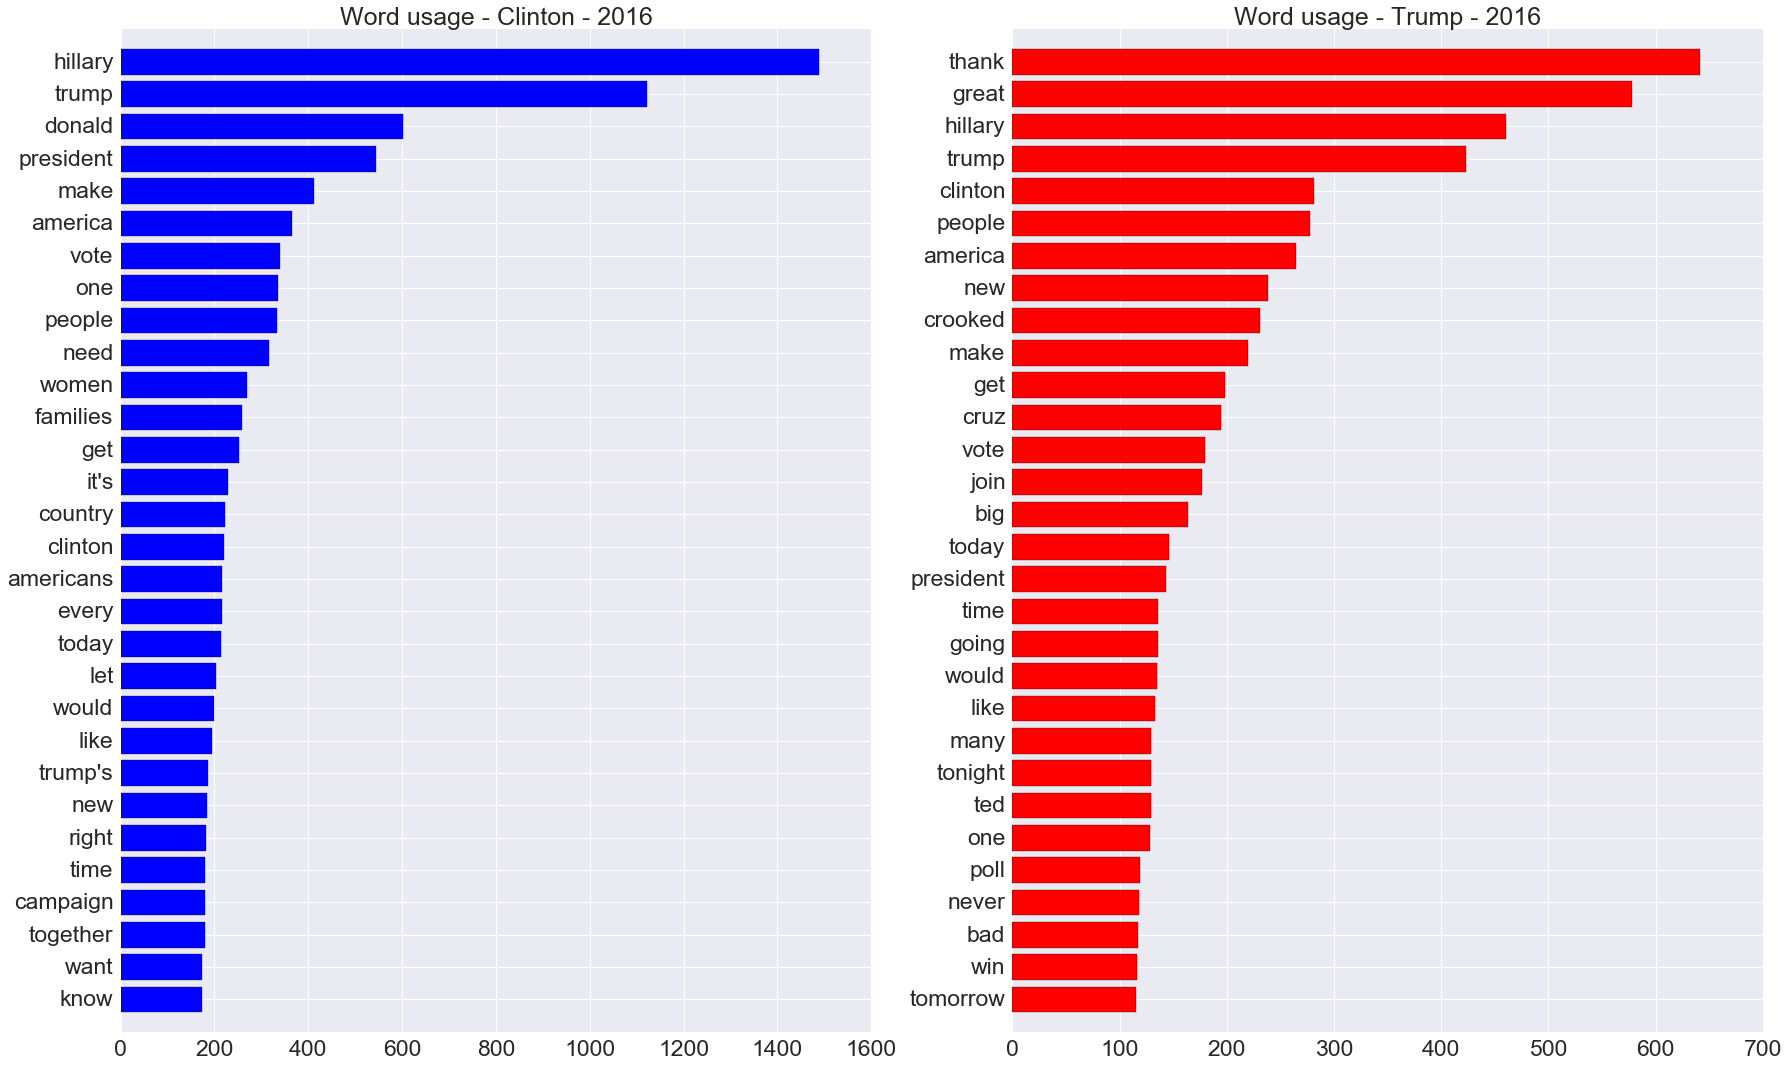

In [25]:
#Barplot of hashtags.
import seaborn as sns 
#plt.style.use('ggplot')
w_num = 30
fig, axes = plt.subplots(1,2, figsize=(25,15))

axes[0].barh(range(w_num), [x[1] for x in hc_tweets_count_2016.most_common(w_num)], align = 'center', color = 'b')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[0].set_yticks(range(w_num))
axes[0].set_yticklabels([x[0] for x in hc_tweets_count_2016.most_common(w_num)], fontsize=20)
axes[0].set_title(r'Word usage - Clinton - 2016', fontsize = 25)
axes[0].set_ylim(bottom=-1)
plt.tight_layout()
axes[0].grid(True)
axes[0].invert_yaxis()
axes[0].tick_params(labelsize=23)

axes[1].barh(range(w_num), [x[1] for x in dt_tweets_count_2016.most_common(w_num)], align = 'center', color = 'r')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[1].set_yticks(range(w_num))
axes[1].set_yticklabels([x[0] for x in dt_tweets_count_2016.most_common(w_num)], fontsize=20)
axes[1].set_title(r'Word usage - Trump - 2016', fontsize = 25)
axes[1].set_ylim(bottom=-1)
axes[1].invert_yaxis()
axes[1].tick_params(labelsize=23)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [11]:
#Testing a porter stemmer... doesn't seem to work great here

from nltk.stem.porter import *
import nltk

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def lemma_tokens(tokens, lemmer):
    lemmatized = []
 #   for item in tokens:
 #       lemmatized.append(lemmer.stem(item))
 #   return stemmed

stemmer = PorterStemmer()
lemmer = nltk.wordnet.WordNetLemmatizer()

temp = []
for tweet in hc_tweets_2016:
    temp.extend(cleanupDoc(tweet, onlytext=True))
    
stemmed = stem_tokens(temp, stemmer)
stemmed_hc = Counter(stemmed)

temp = []
for tweet in dt_tweets_2016:
    temp.extend(cleanupDoc(tweet, onlytext=True))

stemmed = stem_tokens(temp, stemmer)
stemmed_dt = Counter(stemmed)

NameError: name 'hc_tweets_2016' is not defined

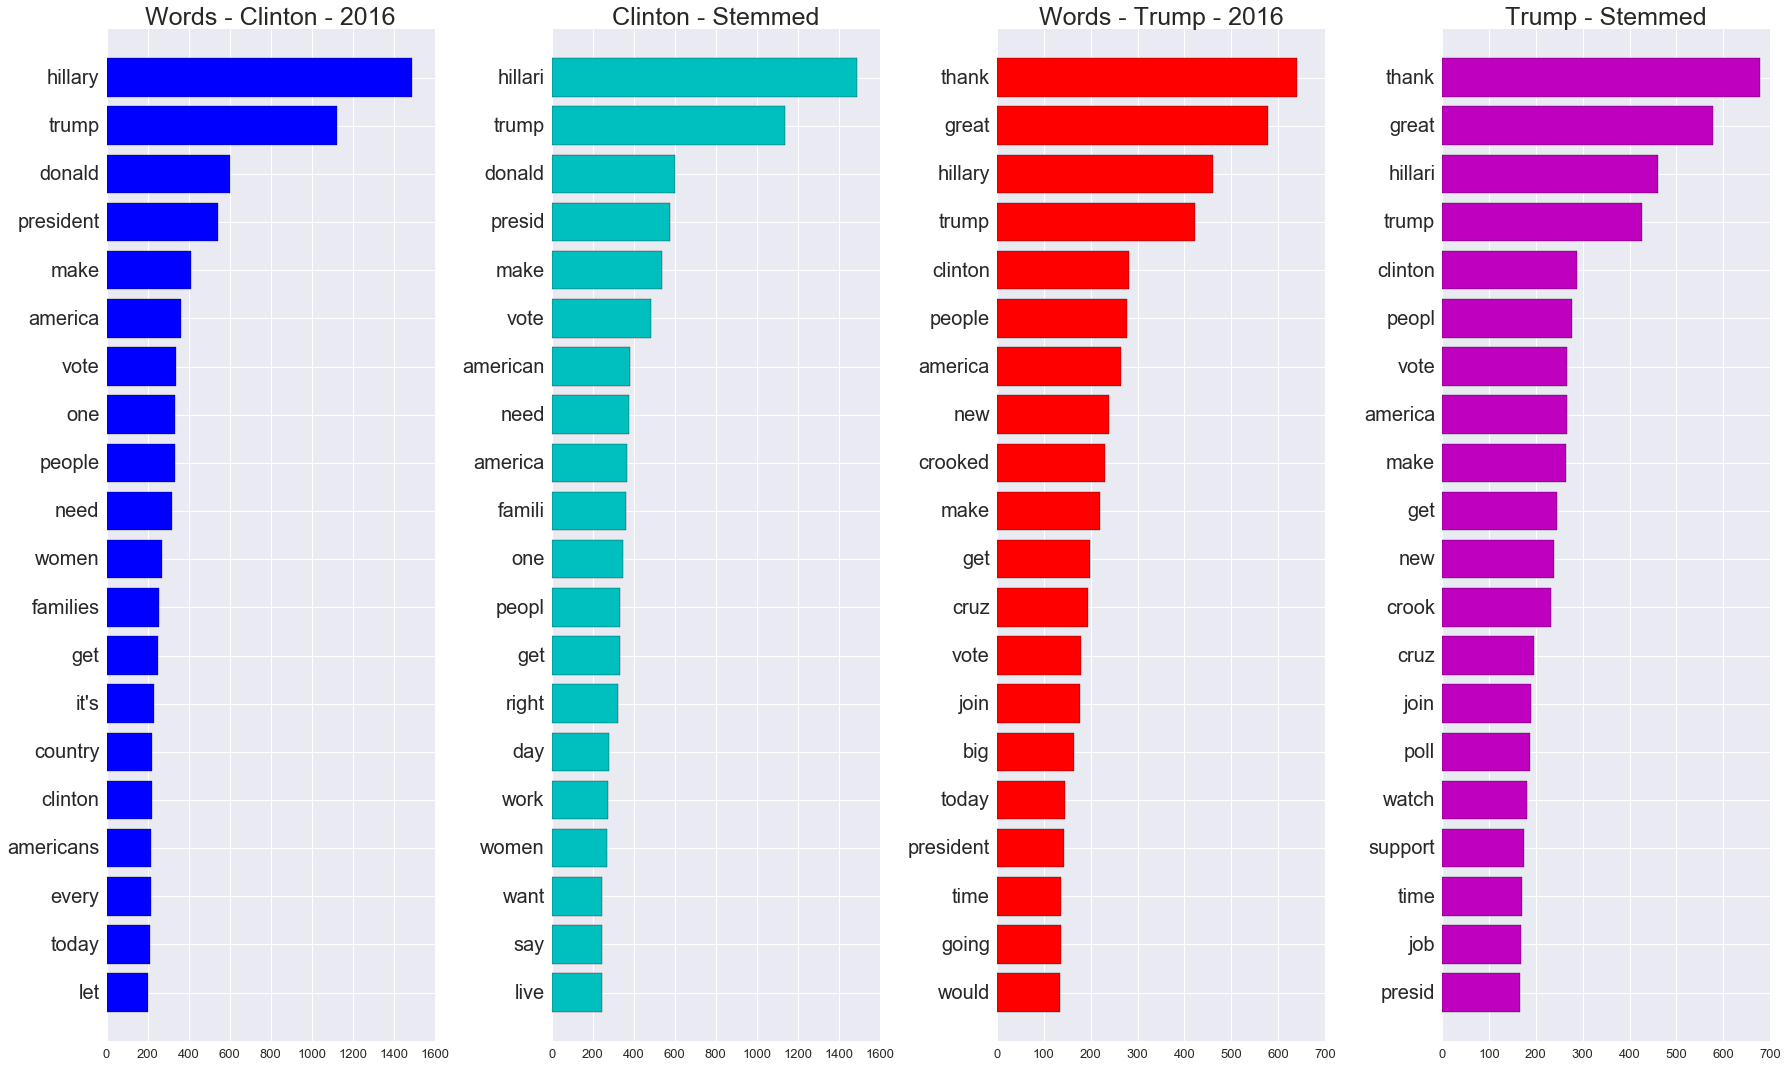

In [27]:
import seaborn as sns

w_num = 20
fig, axes = plt.subplots(1,4, figsize=(25,15))

axes[0].tick_params(labelsize=13)
axes[0].barh(range(w_num), [x[1] for x in hc_tweets_count_2016.most_common(w_num)], align = 'center', color = 'b')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[0].set_yticks(range(w_num))
axes[0].set_yticklabels([x[0] for x in hc_tweets_count_2016.most_common(w_num)], fontsize=20)
axes[0].set_title(r'Words - Clinton - 2016', fontsize = 25)
axes[0].set_ylim(bottom=-1)
axes[0].grid(True)
axes[0].invert_yaxis()

axes[1].tick_params(labelsize=13)
axes[1].barh(range(w_num), [x[1] for x in stemmed_hc.most_common(w_num)], align = 'center', color = 'c')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[1].set_yticks(range(w_num))
axes[1].set_yticklabels([x[0] for x in stemmed_hc.most_common(w_num)], fontsize=20)
axes[1].set_title(r'Clinton - Stemmed', fontsize = 25)
axes[1].set_ylim(bottom=-1)
axes[1].invert_yaxis()
axes[1].grid(True)

axes[2].tick_params(labelsize=13)
axes[2].barh(range(w_num), [x[1] for x in dt_tweets_count_2016.most_common(w_num)], align = 'center', color = 'r')
axes[2].set_yticks(range(w_num))
axes[2].set_yticklabels([x[0] for x in dt_tweets_count_2016.most_common(w_num)], fontsize=20)
axes[2].set_title(r'Words - Trump - 2016', fontsize = 25)
axes[2].set_ylim(bottom=-1)
axes[2].grid(True)
axes[2].invert_yaxis()

axes[3].tick_params(labelsize=13)
axes[3].barh(range(w_num), [x[1] for x in stemmed_dt.most_common(w_num)], align = 'center', color = 'm')
axes[3].set_yticks(range(w_num))
axes[3].set_yticklabels([x[0] for x in stemmed_dt.most_common(w_num)], fontsize=20)
axes[3].set_title(r'Trump - Stemmed', fontsize = 25)
axes[3].set_ylim(bottom=-1)
axes[3].invert_yaxis()
axes[3].grid(True)


plt.tight_layout()
plt.show()

##  5. Predictive model. If we use a machine learning model, how certain are we of the author of the tweet?

In [28]:
#Import machine learning models
import numpy as np

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import SGDClassifier

/Users/carlosjarguello/anaconda/envs/insight_project/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
#How many unique words per candidate?
print 'Clinton unique words: ' + str(len(hc_tweets_count_2016.keys()))
print 'Trump unique words: ' + str(len(dt_tweets_count_2016.keys()))

Clinton unique words: 7494
Trump unique words: 5903


In [30]:
#How many tweets do we have per person?
print 'clinton tweets= ' + str(len(hc_tweets_2016)) + ' trump tweets= ' + str(len(dt_tweets_2016))

clinton tweets= 6406 trump tweets= 4162


In [31]:
X = hc_tweets_2016+dt_tweets_2016;
y = [0 for _ in range(len(hc_tweets_2016))] + [1 for _ in range(len(dt_tweets_2016))]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [33]:
#Vectorizer for going from words -> numbers
vectorizer = TfidfVectorizer(tokenizer=cleanupDoc, min_df=20,
                                 max_df = 0.8,
                                 sublinear_tf=False,
                                 use_idf=True)

In [34]:
X_train = vectorizer.fit_transform(X_train);

In [35]:
#Healthy ratio of features/data? Let's check:
X_train.shape

(8454, 728)

In [36]:
#Choose Logistic Regression as classifier
clf_LR = LogisticRegression(class_weight='balanced')

In [37]:
clf_LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [38]:
X_test = vectorizer.transform(X_test)

In [39]:
pr_LR_test = clf_LR.predict(X_test)

In [40]:
#Evaluate predictive power in validating set
print classification_report(y_test, pr_LR_test, target_names= ['Clinton', 'Trump'])

             precision    recall  f1-score   support

    Clinton       0.85      0.87      0.86      1273
      Trump       0.80      0.77      0.79       841

avg / total       0.83      0.83      0.83      2114



ROC curve

In [41]:
from sklearn.metrics import roc_curve, auc

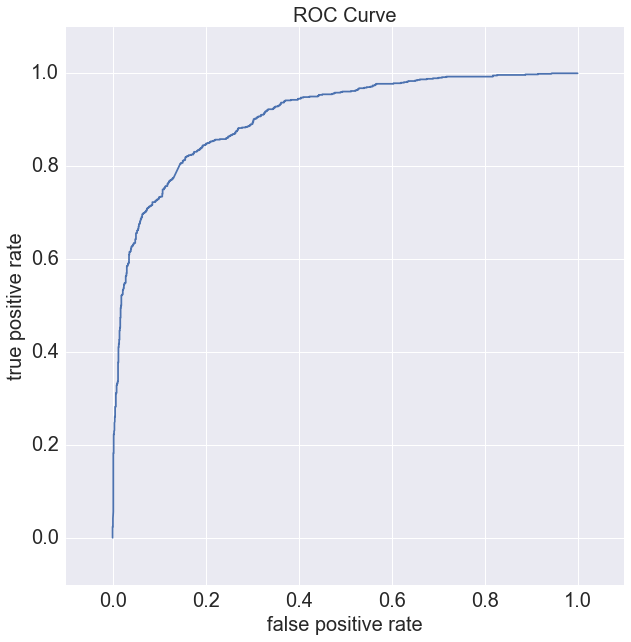

AUC = 0.908425050416


In [42]:
# roc curve
fpr, tpr, threshold = roc_curve(y_test, clf_LR.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

fix, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(fpr, tpr)
plt.title("ROC Curve", fontsize=20)
plt.xlabel("false positive rate", fontsize=20)
plt.ylabel("true positive rate", fontsize=20)
plt.xlim( (-0.1, 1.1) )
plt.ylim( (-0.1, 1.1) )
plt.tick_params(labelsize=20)
plt.show()

print 'AUC = ' + str(roc_auc)

In [43]:
sorted(zip(tpr-fpr,threshold))[-1]

(0.66293913746867394, 0.4748243776177648)

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

In [45]:
cnf_matrix = confusion_matrix(y_test, pr_LR_test, labels=[0, 1])

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 20)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tick_params(labelsize=20)

Normalized confusion matrix
[[ 0.87038492  0.12961508]
 [ 0.22592152  0.77407848]]


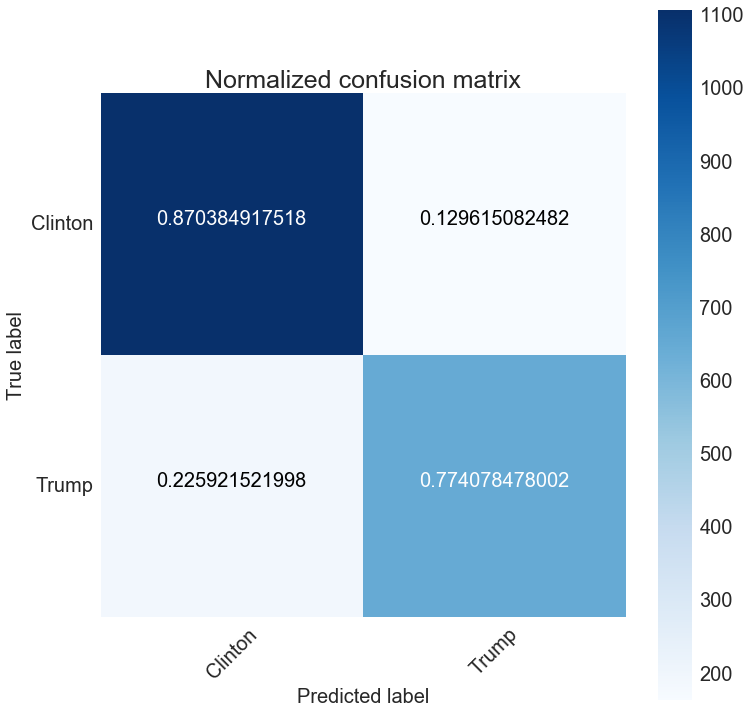

In [47]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
plot_confusion_matrix(cnf_matrix, classes=['Clinton', 'Trump'], normalize=True,
                      title='Normalized confusion matrix')
plt.grid(False)
plt.tick_params(labelsize=20)
plt.show()

In [48]:
vectorizer_cv = TfidfVectorizer(tokenizer=cleanupDoc, min_df=20,
                                 max_df = 0.8,
                                 sublinear_tf=False,
                                 use_idf=True)

In [49]:
scores_cv_f1 = cross_val_score(clf_LR, vectorizer_cv.fit_transform(X), y, cv=5, scoring='f1_macro', n_jobs=-1)

In [50]:
print 'f-1 scores ' + str(scores_cv_f1) 
print 'mean = ' +  str(scores_cv_f1.mean()) + '   std=  ' + str(scores_cv_f1.std())

f-1 scores [ 0.82159946  0.78324314  0.79607721  0.80149197  0.83765297]
mean = 0.808012950364   std=  0.0192958695925


In [51]:
#Tuning hyperparameters
Cs = np.logspace(-1, 1, 15)

In [52]:
Cs

array([  0.1       ,   0.13894955,   0.19306977,   0.26826958,
         0.37275937,   0.51794747,   0.71968567,   1.        ,
         1.38949549,   1.93069773,   2.6826958 ,   3.72759372,
         5.17947468,   7.19685673,  10.        ])

In [53]:
clf_LR_Hyp = GridSearchCV(estimator=clf_LR, param_grid=dict(C=Cs), cv = 5, scoring = 'f1_macro', n_jobs=-1)

In [54]:
clf_LR_Hyp.fit(vectorizer_cv.transform(X),y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  0.1    ,   0.13895,   0.19307,   0.26827,   0.37276,   0.51795,
         0.71969,   1.     ,   1.3895 ,   1.9307 ,   2.6827 ,   3.72759,
         5.17947,   7.19686,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [55]:
print clf_LR_Hyp.best_params_, clf_LR_Hyp.best_score_

{'C': 1.0} 0.808013177769


### Now the fun part... We saw Clinton's/Trump's hashtags/words. The model is (reasonably) successful in predicting tweets authored by each candidate. What are the most relevant features to define a given class? (i.e., what does a tweet have to say to be more "Clintoney" or "Trumpey"?

In [56]:
#Function to extract most important features from classifier (by coeficient value)
def show_most_informative_features(vectorizer, clf, n=20, printing=False):
    feature_names = vectorizer.get_feature_names()
    try:
        coefs_list = np.array(clf.coef_.todense()).flatten()
    except:
        coefs_list = np.array(clf.coef_.flatten())
    coefs_with_fns = sorted(zip(coefs_list, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    out1 =[]
    out2 =[]
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        if printing:
            print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
        else:
            out1.append((fn_1, abs(coef_1)))
            out2.append((fn_2, abs(coef_2)))
    if not printing:
        return sorted(out1, key=lambda x:x[1], reverse=True), sorted(out2, key=lambda x:x[1], reverse=True)

### And... Clinton vs Trump speech (as classified by the model), using all tweets:

In [57]:
clf_LR = LogisticRegression(C=1.38, class_weight='balanced')
clf_LR.fit(vectorizer.fit_transform(X), y)

LogisticRegression(C=1.38, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [58]:
show_most_informative_features(vectorizer, clf_LR, 40, printing=True)

	-5.5910	hillary        		8.4561	crooked        
	-3.3268	climate        		5.0919	great          
	-3.2049	here's         		4.5033	cruz           
	-3.1216	flint          		4.2177	media          
	-3.0028	kids           		4.0085	poll           
	-2.9891	donald         		3.7850	thank          
	-2.9854	families       		3.4363	bad            
	-2.7421	we're          		3.2559	donaldtrump    
	-2.7013	equality       		3.2224	jeb            
	-2.6851	gun            		3.2172	clinton        
	-2.6629	matter         		3.1804	enjoy          
	-2.6428	progress       		3.0473	nice           
	-2.5440	trail          		2.9526	failed         
	-2.4787	los            		2.8622	rubio          
	-2.4660	que            		2.8363	cnn            
	-2.4623	commander-in-chief		2.8241	dishonest      
	-2.4076	fear           		2.7544	wow            
	-2.3806	every          		2.6285	radical        
	-2.3546	stronger       		2.6221	ratings        
	-2.3456	republicans    		2.5635	video          
	-2.3063	chip    

In [59]:
coefs1, coefs2 = show_most_informative_features(vectorizer, clf_LR, 40)

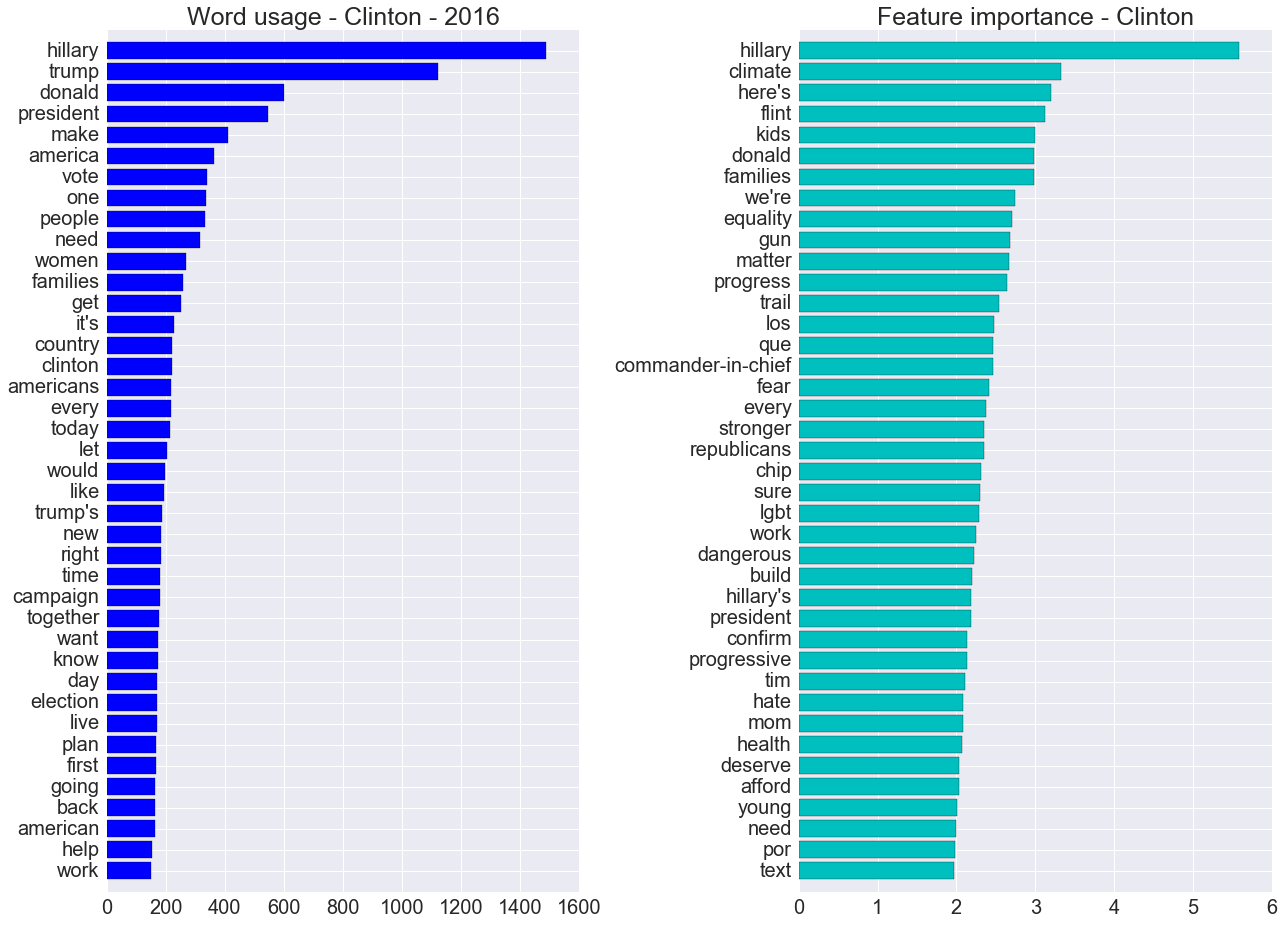

In [60]:
#Barplot of hashtags.
import seaborn as sns 
#plt.style.use('ggplot')
w_num = 40
fig, axes = plt.subplots(1,2, figsize=(18,13))

axes[0].barh(range(w_num), [x[1] for x in hc_tweets_count_2016.most_common(w_num)], align = 'center', color = 'b')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[0].set_yticks(range(w_num))
axes[0].set_yticklabels([x[0] for x in hc_tweets_count_2016.most_common(w_num)], fontsize=20)
axes[0].set_title(r'Word usage - Clinton - 2016', fontsize = 25)
axes[0].set_ylim(bottom=-1)
plt.tight_layout()
axes[0].grid(True)
axes[0].invert_yaxis()
axes[0].tick_params(labelsize=20)

axes[1].barh(range(w_num), [x[1] for x in coefs1], align = 'center', color = 'c')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[1].set_yticks(range(w_num))
axes[1].set_yticklabels([x[0] for x in coefs1], fontsize=20)
axes[1].set_title(r'Feature importance - Clinton', fontsize = 25)
axes[1].set_ylim(bottom=-1)
axes[1].invert_yaxis()
axes[1].tick_params(labelsize=20)
axes[1].grid(True)

plt.tight_layout()
plt.show()

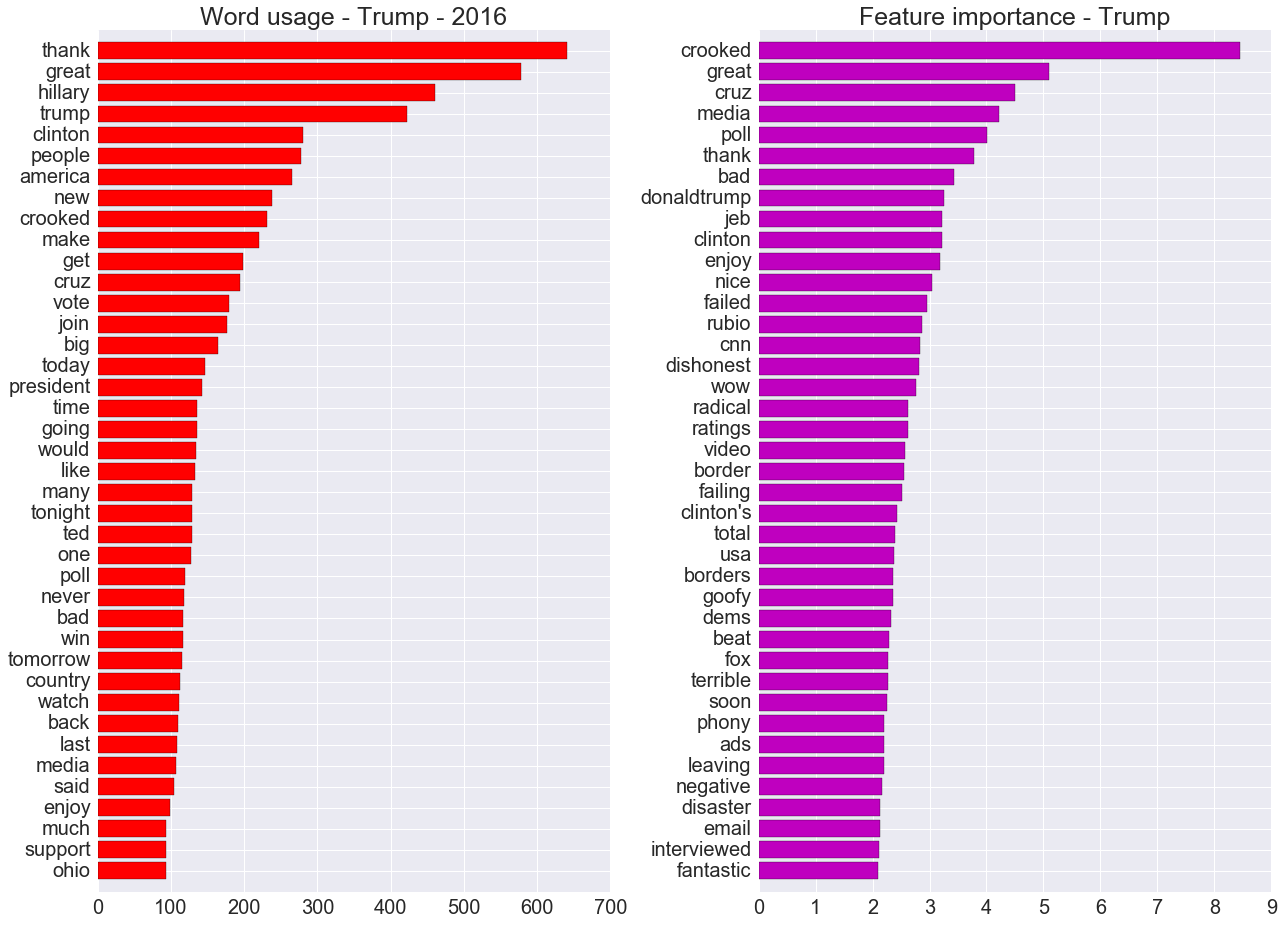

In [61]:
#Barplot of hashtags.
import seaborn as sns 
#plt.style.use('ggplot')
w_num = 40
fig, axes = plt.subplots(1,2, figsize=(18,13))

axes[0].barh(range(w_num), [x[1] for x in dt_tweets_count_2016.most_common(w_num)], align = 'center', color = 'r')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[0].set_yticks(range(w_num))
axes[0].set_yticklabels([x[0] for x in dt_tweets_count_2016.most_common(w_num)], fontsize=20)
axes[0].set_title(r'Word usage - Trump - 2016', fontsize = 25)
axes[0].set_ylim(bottom=-1)
plt.tight_layout()
axes[0].grid(True)
axes[0].invert_yaxis()
axes[0].tick_params(labelsize=20)

axes[1].barh(range(w_num), [x[1] for x in coefs2], align = 'center', color = 'm')
#axes[0].set_ylabel('Words', fontsize = 25)
axes[1].set_yticks(range(w_num))
axes[1].set_yticklabels([x[0] for x in coefs2], fontsize=20)
axes[1].set_title(r'Feature importance - Trump', fontsize = 25)
axes[1].set_ylim(bottom=-1)
axes[1].invert_yaxis()
axes[1].tick_params(labelsize=20)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## ----------------- Old analysis

In [197]:
np.random.shuffle(hc_tweets_2016)
np.random.shuffle(dt_tweets_2016)

In [198]:
#Vectorizer for going from words -> numbers
vectorizer = TfidfVectorizer(tokenizer=cleanupDoc, min_df=18,
                                 max_df = 0.8,
                                 sublinear_tf=False,
                                 use_idf=True)

In [199]:
#Pick subset of data to train a predictive model with Trump/Clinton classes
clinton_train = hc_tweets_2016[:3200]; trump_train = dt_tweets_2016[:2100]

In [200]:
X_train = vectorizer.fit_transform(clinton_train+trump_train);
y_train = ['Clinton' for _ in range(len(clinton_train))] + ['Trump' for _ in range(len(trump_train))]

In [201]:
#Healthy ratio of features/data? Let's check:
X_train.shape

(5300, 518)

In [202]:
#Choose SVM/linear kernel as classifier
clf_linear = svm.SVC(kernel='linear')

In [203]:
clf_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [204]:
#Define validation set
trump_val = dt_tweets_2016[2100:3000]; clinton_val = hc_tweets_2016[3200:4200];
y_val = ['Clinton' for _ in range(len(clinton_val))] + ['Trump' for _ in range(len(trump_val))]

In [205]:
pr_linear_val = clf_linear.predict(vectorizer.transform(clinton_val+trump_val))

In [222]:
#Evaluate predictive power in validating set
print classification_report(y_val, pr_linear_val)

             precision    recall  f1-score   support

    Clinton       0.75      0.92      0.83      1000
      Trump       0.88      0.67      0.76       900

avg / total       0.81      0.80      0.79      1900



### And... Clinton vs Trump speech (as classified by the model)

In [400]:
show_most_informative_features(vectorizer, clf_linear, 20)

	-3.7339	flint          		6.2492	color          
	-2.6406	care           		3.5205	interviewed    
	-2.4795	rubio          		3.0979	face           
	-2.4425	education      		2.9709	comes          
	-2.2434	delegates      		2.9640	caucus         
	-2.2072	fact           		2.9203	got            
	-2.1845	speech         		2.6848	attack         
	-2.1575	first          		2.6624	make           
	-2.0449	crazy          		2.4469	leadership     
	-2.0237	men            		2.3973	mom            
	-2.0105	super          		2.2832	disaster       
	-1.9682	instead        		2.2268	night          
	-1.9397	change         		2.1982	minimum        
	-1.9061	replace        		2.1973	ready          
	-1.8855	means          		2.1941	apart          
	-1.8827	action         		2.1644	serve          
	-1.8719	joke           		2.1329	discrimination 
	-1.8709	don't          		2.0559	donaldtrump    
	-1.8607	dream          		2.0551	career         
	-1.8336	here's         		2.0427	nuclear        


Good predictive power! Let's check on the test set:

In [207]:
#Define test set for classifier
trump_test = dt_tweets_2016[3000:]; clinton_test = hc_tweets_2016[4200:]
y_test = ['Clinton' for _ in range(len(clinton_test))] + ['Trump' for _ in range(len(trump_test))]

In [208]:
pr_linear_test = clf_linear.predict(vectorizer.transform(clinton_test+trump_test))

In [209]:
#Evaluate predictive power in test set
print classification_report(y_test, pr_linear_test)

             precision    recall  f1-score   support

    Clinton       0.84      0.92      0.88      2206
      Trump       0.81      0.67      0.73      1162

avg / total       0.83      0.83      0.83      3368



Not bad!!! We're not overfitting...

In [210]:
clf_LR = LogisticRegression(class_weight='balanced')
clf_LR.fit(X_train, y_train)
pr_LR_val = clf_LR.predict(vectorizer.transform(clinton_val+trump_val))

In [211]:
#Evaluate predictive power in validating set
print classification_report(y_val, pr_LR_val)

             precision    recall  f1-score   support

    Clinton       0.80      0.83      0.82      1000
      Trump       0.81      0.77      0.79       900

avg / total       0.80      0.80      0.80      1900



### Now the fun part... We saw Clinton's/Trump's hashtags/words. The model is (reasonably) successful in predicting tweets authored by each candidate. What are the most relevant features to define a given class? (i.e., what does a tweet have to say to be more "Clintoney" or "Trumpey"?

In [219]:
#Function to extract most important features from classifier (by coeficient value)
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    try:
        coefs_list = np.array(clf.coef_.todense()).flatten()
    except:
        coefs_list = np.array(clf.coef_.flatten())
    coefs_with_fns = sorted(zip(coefs_list, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

### And... Clinton vs Trump speech (as classified by the model)

In [220]:
show_most_informative_features(vectorizer, clf_linear, 20)

	-2.8579	hillary        		5.7154	crooked        
	-2.0747	donald         		4.2682	media          
	-1.9838	tim            		3.5141	great          
	-1.9227	climate        		3.0129	cruz           
	-1.8668	here's         		2.9586	ratings        
	-1.7340	commander-in-chief		2.7527	jeb            
	-1.7204	start          		2.6542	rubio          
	-1.6951	trail          		2.6300	thank          
	-1.6402	gun            		2.5683	wow            
	-1.6322	young          		2.4464	total          
	-1.4990	work           		2.4122	wonderful      
	-1.4878	black          		2.3204	watching       
	-1.4831	equality       		2.2967	border         
	-1.4607	grateful       		2.2953	enjoy          
	-1.4458	progress       		2.2438	clinton        
	-1.4313	we're          		2.1983	true           
	-1.4142	kids           		2.1538	failed         
	-1.4093	para           		2.0137	massive        
	-1.4078	president      		2.0097	nice           
	-1.3943	it's           		1.9398	bad            


## ------------------

## 6. Using Latent Dirichlet Allocation: Can we find 3 different topics by politician?

In [62]:
import gensim
from gensim import corpora, models

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:

In [63]:
hc_tweets_2016[0]

u'We have a responsibility to fight for the next generation. All of us. #TBT\nhttps://t.co/p4FcuCcVmW'

In [64]:
dictionary_hc = corpora.Dictionary([cleanupDoc(x, onlytext=True) for x in hc_tweets_2016])
dictionary_dt = corpora.Dictionary([cleanupDoc(x, onlytext=True) for x in dt_tweets_2016])

The Dictionary() function traverses texts, assigning a unique integer id to each unique token while also collecting word counts and relevant statistics. To see each token’s unique integer id, try print(dictionary.token2id).

In [65]:
#convert to bag-of-words:
corpus_hc = [dictionary_hc.doc2bow(text) for text in [cleanupDoc(x, onlytext=True) for x in hc_tweets_2016]]
corpus_dt = [dictionary_dt.doc2bow(text) for text in [cleanupDoc(x, onlytext=True) for x in dt_tweets_2016]]

This list of tuples represents our first document, doc_a. The tuples are (term ID, term frequency) pairs, so if print(dictionary.token2id) says brocolli’s id is 0, then the first tuple indicates that brocolli appeared twice in doc_a. doc2bow() only includes terms that actually occur: terms that do not occur in a document will not appear in that document’s vector.

In [66]:
#Fitting model
ldamodel_hc = gensim.models.ldamodel.LdaModel(corpus_hc, num_topics=3, id2word = dictionary_hc, passes=30)
ldamodel_dt = gensim.models.ldamodel.LdaModel(corpus_dt, num_topics=3, id2word = dictionary_dt, passes=30)

Once the model is fitted, let's see if we can distinguish some topics:

In [67]:
print(ldamodel_hc.print_topics(num_topics=3, num_words=20)[0][1])
print(ldamodel_hc.print_topics(num_topics=3, num_words=20)[1][1])
print(ldamodel_hc.print_topics(num_topics=3, num_words=20)[2][1])

0.035*"hillary" + 0.016*"president" + 0.010*"people" + 0.010*"trump" + 0.008*"together" + 0.007*"need" + 0.007*"live" + 0.007*"country" + 0.006*"watch" + 0.006*"clinton" + 0.006*"families" + 0.006*"new" + 0.006*"campaign" + 0.006*"vote" + 0.006*"americans" + 0.005*"america" + 0.005*"gun" + 0.005*"first" + 0.005*"one" + 0.005*"get"
0.028*"trump" + 0.023*"hillary" + 0.019*"donald" + 0.015*"make" + 0.010*"one" + 0.009*"america" + 0.008*"president" + 0.008*"let" + 0.006*"trump's" + 0.006*"election" + 0.006*"would" + 0.006*"like" + 0.005*"get" + 0.005*"plan" + 0.005*"never" + 0.005*"vote" + 0.005*"people" + 0.005*"great" + 0.005*"going" + 0.005*"sure"
0.018*"trump" + 0.012*"women" + 0.010*"rights" + 0.009*"hillary" + 0.009*"donald" + 0.008*"night" + 0.004*"isn't" + 0.004*"right" + 0.004*"last" + 0.004*"words" + 0.004*"best" + 0.004*"still" + 0.004*"it's" + 0.004*"que" + 0.004*"years" + 0.003*"los" + 0.003*"lgbt" + 0.003*"say" + 0.003*"deserve" + 0.003*"equality"


In [68]:
print(ldamodel_dt.print_topics(num_topics=3, num_words=20)[0][1])
print(ldamodel_dt.print_topics(num_topics=3, num_words=20)[1][1])
print(ldamodel_dt.print_topics(num_topics=3, num_words=20)[2][1])

0.014*"kasich" + 0.012*"ohio" + 0.012*"rubio" + 0.010*"people" + 0.010*"dishonest" + 0.009*"marco" + 0.009*"media" + 0.008*"lightweight" + 0.007*"phony" + 0.007*"trump" + 0.007*"senator" + 0.006*"nafta" + 0.006*"cruz" + 0.005*"totally" + 0.005*"voted" + 0.005*"state" + 0.005*"another" + 0.005*"one" + 0.005*"put" + 0.004*"remember"
0.021*"hillary" + 0.012*"trump" + 0.012*"clinton" + 0.009*"crooked" + 0.009*"people" + 0.008*"president" + 0.007*"win" + 0.007*"don't" + 0.006*"never" + 0.006*"jobs" + 0.006*"like" + 0.006*"bernie" + 0.005*"candidate" + 0.005*"bad" + 0.005*"much" + 0.005*"time" + 0.005*"cruz" + 0.005*"would" + 0.004*"ted" + 0.004*"want"
0.052*"thank" + 0.041*"great" + 0.020*"america" + 0.015*"make" + 0.012*"vote" + 0.012*"new" + 0.012*"big" + 0.012*"trump" + 0.010*"join" + 0.009*"tomorrow" + 0.009*"ohio" + 0.008*"today" + 0.007*"michigan" + 0.007*"kansas" + 0.007*"amazing" + 0.007*"tonight" + 0.007*"florida" + 0.007*"morning" + 0.006*"people" + 0.006*"carolina"


"This explanation is a little lengthy, but useful for understanding the model we worked so hard to generate.

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution, like the ones in our walkthrough model. In other words, LDA assumes a document is made from the following steps:

Determine the number of words in a document. Let’s say our document has 6 words.
Determine the mixture of topics in that document. For example, the document might contain 1/2 the topic “health” and 1/2 the topic “vegetables.”
Using each topic’s multinomial distribution, output words to fill the document’s word slots. In our example, the “health” topic is 1/2 our document, or 3 words. The “health” topic might have the word “diet” at 20% probability or “exercise” at 15%, so it will fill the document word slots based on those probabilities.
Given this assumption of how documents are created, LDA backtracks and tries to figure out what topics would create those documents in the first place."

In [69]:
dt_topicdist = {"Candidate" : "Trump", "Topic 1" : 0, "Topic 2" : 0, "Topic 3" : 0}
hc_topicdist = {"Candidate" : "Clinton", "Topic 1" : 0, "Topic 2" : 0, "Topic 3" : 0}

In [70]:
for x in corpus_dt:
    dt_topicdist['Topic ' + str(sorted(ldamodel_dt[x], key = lambda x: x[1])[-1][0]+1)] += 1/len(corpus_dt)

In [71]:
for x in corpus_hc:
    hc_topicdist['Topic ' + str(sorted(ldamodel_hc[x], key = lambda x: x[1])[-1][0]+1)] += 1/len(corpus_hc)

In [72]:
df_topics = pd.DataFrame.from_dict([hc_topicdist,dt_topicdist])

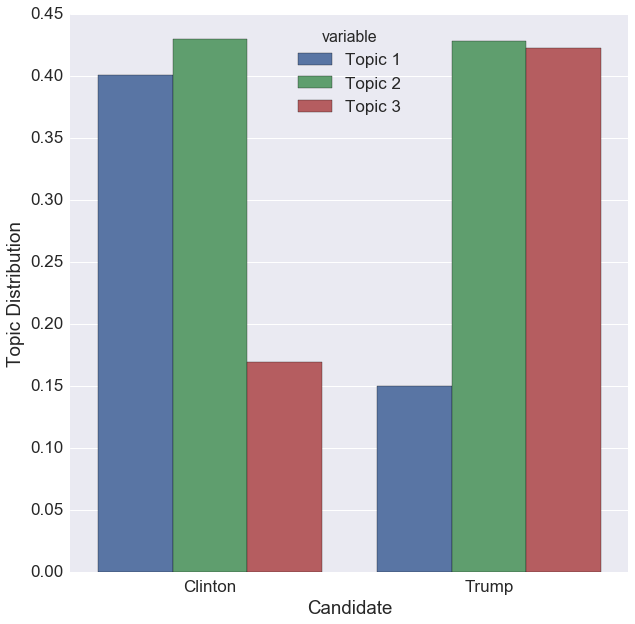

In [73]:
with sns.plotting_context("notebook", font_scale=1.7):
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    sns.barplot(x='Candidate', y='value', hue='variable', data = pd.melt(df_topics, id_vars=['Candidate'], value_vars=['Topic 1', 'Topic 2', 'Topic 3']))
    ax.set_ylabel('Topic Distribution')
plt.show()

## Word2Vec - Merely an academic exercise with the tweets. Find word similarity based on tweet context

In [121]:
#Import word2vec model from gensim, define parameters
from gensim.models import Word2Vec
min_count = 20    #Minimum frequency of words 
size = 50   #Dimensionality of vector space
window = 6  #Maximum separation of words
sg = 1 #0 = CBOW, 1 = Skip-gram 

In [132]:
model_hc = Word2Vec([cleanupDoc(x) for x in hc_tweets_2016], min_count=min_count, size=size, window=window,sg=sg, iter=10)
model_dt = Word2Vec([cleanupDoc(x) for x in dt_tweets_2016], min_count=min_count, size=size, window=window, sg=sg, iter=10)

In [137]:
model_dt.most_similar(positive=['hillary','clinton'])

[(u'crooked', 0.9943569302558899),
 (u'system', 0.9893661141395569),
 (u'judgement', 0.9889804124832153),
 (u'rigged', 0.9870630502700806),
 (u'sanders', 0.9848108291625977),
 (u'bad', 0.9825494885444641),
 (u'bernie', 0.9800164103507996),
 (u'obama', 0.9791904091835022),
 (u'run', 0.9701425433158875),
 (u'person', 0.9689415693283081)]

In [138]:
model_dt.most_similar(positive=['america'])

[(u'safe', 0.98368901014328),
 (u'make', 0.980065107345581),
 (u'together', 0.9696149826049805),
 (u'great', 0.9430915713310242),
 (u'going', 0.903590202331543),
 (u'bring', 0.8768895864486694),
 (u'back', 0.8684784173965454),
 (u'vote', 0.8594164848327637),
 (u'2016', 0.847091794013977),
 (u'jobs', 0.8412578105926514)]

In [139]:
model_hc.most_similar(positive=['donald','trump'])

[(u"he's", 0.9442315101623535),
 (u'lot', 0.9357750415802002),
 (u'really', 0.9299576282501221),
 (u'high', 0.922299861907959),
 (u'says', 0.9186044335365295),
 (u'called', 0.9152300357818604),
 (u'times', 0.9119310975074768),
 (u'said', 0.911064863204956),
 (u'isis', 0.9102686643600464),
 (u'smart', 0.9050823450088501)]

In [140]:
model_hc.most_similar(positive=['america'])

[(u'great', 0.9306858777999878),
 (u'getting', 0.8618543744087219),
 (u'everything', 0.8517938256263733),
 (u'always', 0.840912938117981),
 (u'better', 0.8176175355911255),
 (u'vision', 0.8170666694641113),
 (u'whole', 0.8022629022598267),
 (u'nation', 0.7949260473251343),
 (u'love', 0.7930557727813721),
 (u'believe', 0.7871644496917725)]